In [4]:
#%pip install pandas numpy scikit-learn matplotlib tensorflow tensorflow-privacy s3fs python-dotenv lakefs-client

In [5]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [84]:
LAKEFS_KEY = os.getenv("LAKEFS_KEY")
LAKEFS_SECRET = os.getenv("LAKEFS_SECRET")

storage_options = {
    "key": LAKEFS_KEY,
    "secret": LAKEFS_SECRET,
    "client_kwargs": {
        "endpoint_url": "http://localhost:8000"
    }
}

## V1

In [ ]:
'''lakectl fs download \
  lakefs://ml-ops-hw1-athletes/main/athletes_main.csv \
  athletes_main.csv'''

In [6]:
# v1 = raw data from 'main' branch
df_v1 = pd.read_csv("athletes_main.csv")
df_v1.head()

,athlete_id,name,region,team,affiliate,gender,age,height,weight,fran,...,snatch,deadlift,backsq,pullups,eat,train,background,experience,schedule,howlong
0,2554.0,Pj Ablang,South West,Double Edge,Double Edge CrossFit,Male,24.0,70.0,166.0,NaN,...,NaN,400.0,305.0,NaN,NaN,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|I r...,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
1,3517.0,Derek Abdella,NaN,NaN,NaN,Male,42.0,70.0,190.0,NaN,...,NaN,NaN,NaN,NaN,NaN,I have a coach who determines my programming|I...,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
2,4691.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5164.0,Abo Brandon,Southern California,LAX CrossFit,LAX CrossFit,Male,40.0,67.0,NaN,211.0,...,200.0,375.0,325.0,25.0,I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|,4+ years|
4,5286.0,Bryce Abbey,NaN,NaN,NaN,Male,32.0,65.0,149.0,206.0,...,150.0,NaN,325.0,50.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I inc...,I played college sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|I strictly s...,1-2 years|


### Cleaning

In [7]:
# create total_lift variable only for v1 (already included in v2)
df_v1['total_lift'] = (
    df_v1['deadlift'] +
    df_v1['candj']     +
    df_v1['snatch']    +
    df_v1['backsq']
)

# remove incompatible columns
df_v1_clean = df_v1.dropna(subset=['region','age','weight','height','howlong','gender','eat', 'train','background','experience','schedule','howlong', 'deadlift','candj','snatch','backsq','experience', 'background','schedule','howlong', 'total_lift'])

df_v1_clean = df_v1_clean.drop(columns=['affiliate','team','name','athlete_id','fran','helen','grace','filthy50','fgonebad','run400','run5k','pullups','train', 'howlong', 'schedule', 'background', 'experience', 'eat'])

obj_cols = df_v1_clean.select_dtypes(include="object").columns
print("Non-numeric columns that will break the model:", list(obj_cols))

Non-numeric columns that will break the model: ['region', 'gender']


In [8]:
# compute per region average lift
region_means = df_v1_clean.groupby("region")["total_lift"].mean()
region_encoding_df = (region_means.reset_index().rename(columns={"total_lift": "region_mean_lift"}).sort_values("region_mean_lift", ascending=False))
print(region_encoding_df)

                 region  region_mean_lift
5          Central East       7938.657308
2             Australia       5646.520868
13        South Central       1024.558087
9         North Central       1016.131030
14           South East       1013.012307
8          Mid Atlantic        998.192533
4           Canada West        992.341495
15           South West        992.057527
0                Africa        990.128107
11           North West        989.520635
16  Southern California        989.064877
12  Northern California        982.407957
10           North East        976.852077
1                  Asia        972.488827
6                Europe        971.905989
3           Canada East        971.641087
7         Latin America        954.491465


In [9]:
df_v1_clean["region_mean_lift"] = df_v1_clean["region"].map(region_means)

#remove region column
df_v1_clean = df_v1_clean.drop('region', axis=1)

In [10]:
df_v1_clean.columns

Index(['gender', 'age', 'height', 'weight', 'candj', 'snatch', 'deadlift',
       'backsq', 'total_lift', 'region_mean_lift'],
      dtype='object')

In [11]:
# one hot encode gender
df_v1_clean = df_v1_clean.dropna(subset='gender')
df_v1_clean = pd.get_dummies(df_v1_clean, columns=['gender'], drop_first=True)
print(df_v1_clean.filter(like="gender_").head())

    gender_Female  gender_Male
6           False         True
13          False         True
21          False         True
22          False         True
27          False         True


### EDA

v1 shape: (32172, 11)
                 age        height        weight         candj        snatch  \
count   32172.000000  3.217200e+04  32172.000000  32172.000000  32172.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean       32.039102  3.293735e+02    176.874145    200.764671    152.999658   
std         7.510193  4.676784e+04     33.551862     73.657046     73.820043   
min        14.000000  0.000000e+00      5.000000    -45.000000      0.000000   
25%        27.000000  6.600000e+01    155.000000    155.000000    115.000000   
50%        31.000000  6.900000e+01    178.000000    205.000000    155.000000   
75%        37.000000  7.200000e+01    196.000000    245.000000    190.000000   
max        56.000000  8.388607e+06   1750.000000   5000.000000   8095.000000   

            deadl

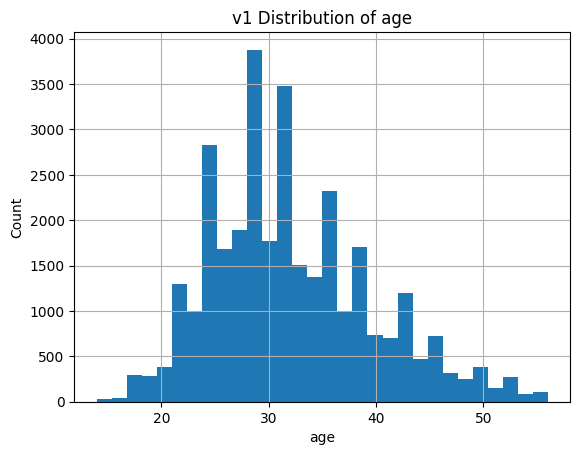

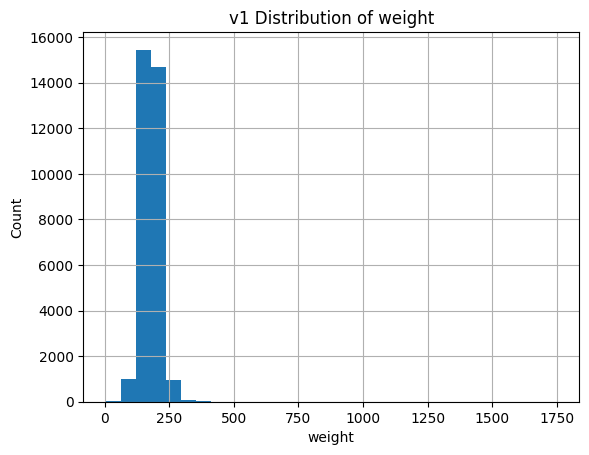

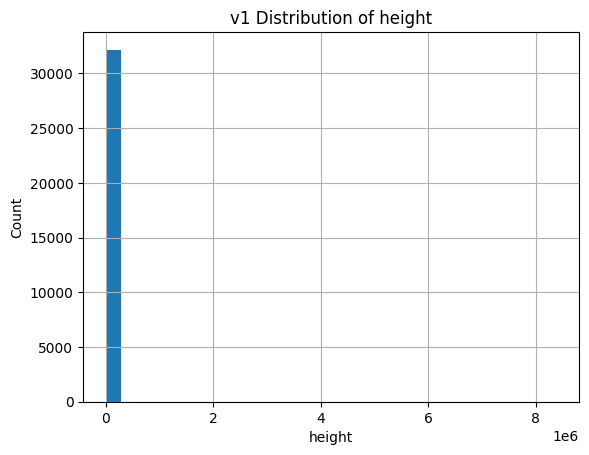

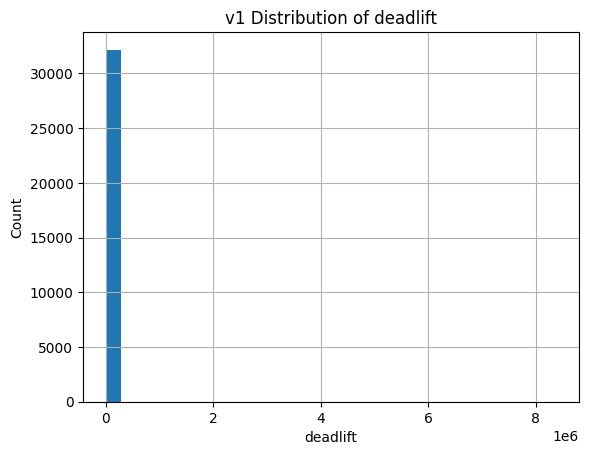

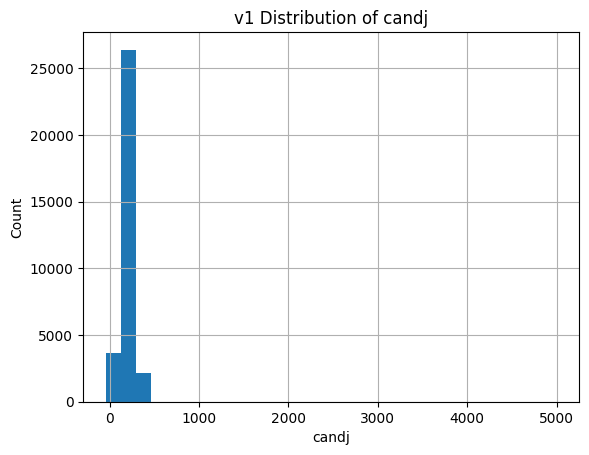

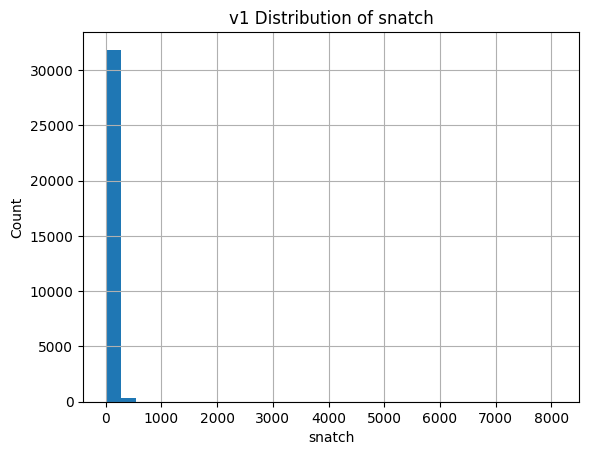

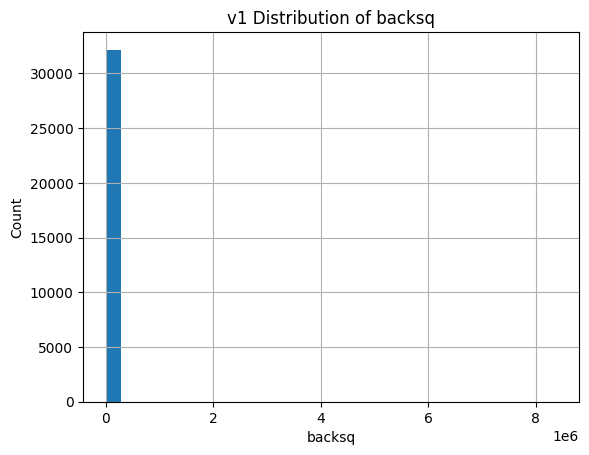

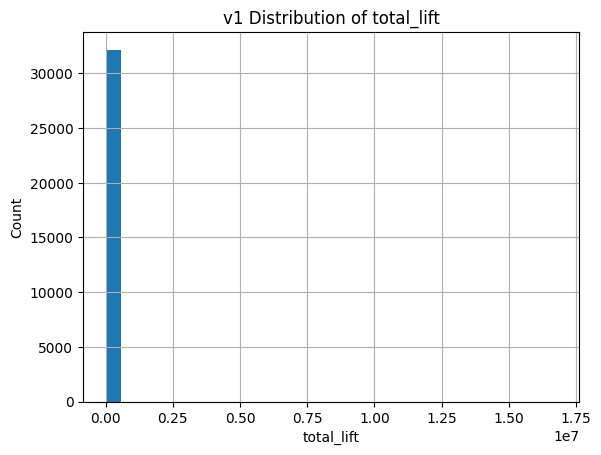

In [12]:
print("v1 shape:", df_v1_clean.shape)
print(df_v1_clean.describe(include="all"))

# Histograms of key numeric features
for col in ["age", "weight", "height", "deadlift", "candj", "snatch", "backsq", "total_lift"]:
    plt.figure()
    df_v1_clean[col].hist(bins=30)
    plt.title(f"v1 Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

### Model

In [13]:
# Baseline model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import json

X = df_v1_clean.drop(columns=["total_lift","total_lift", "candj", "snatch", "deadlift","backsq"], axis=1)
y = df_v1_clean['total_lift']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X,y,test_size=0.2, random_state=32)

model1 = RandomForestRegressor(random_state=32)
model1.fit(X_train_1,y_train_1)
y_pred_1 = model1.predict(X_test_1)

metrics_v1 = {
    "MAE": mean_absolute_error(y_test_1,y_pred_1),
    "R2": r2_score(y_test_1,y_pred_1)
}
print("Model 1 (v1) Metrics:", metrics_v1)


Model 1 (v1) Metrics: {'MAE': 2764.0091656690665, 'R2': -143413.14511409483}


In [14]:
df_v1_clean.to_csv("athletes_v1.csv", index=False)

In [ ]:
'''lakectl fs upload \
  lakefs://ml-ops-hw1-athletes/v1/athletes.csv \
  --source athletes_v1.csv'''

'''lakectl commit \
  lakefs://ml-ops-hw1-athletes/v1 \
  -m "v1: minimal cleaning + total_lift"'''

## V2
Copy of df_v1 to df (workable data that will be saved as v2)

In [ ]:
'''lakectl fs download \
  lakefs://ml-ops-hw1-athletes/v1/athletes.csv \
  athletes_v1.csv'''

In [15]:
df_v2 = pd.read_csv("athletes_v1.csv")
df_v2

,age,height,weight,candj,snatch,deadlift,backsq,total_lift,region_mean_lift,gender_Female,gender_Male
0,21.0,72.0,175.0,0.0,0.0,0.0,0.0,0.0,1024.558087,False,True
1,43.0,71.0,185.0,0.0,0.0,0.0,0.0,0.0,7938.657308,False,True
2,30.0,71.0,200.0,235.0,175.0,385.0,315.0,1110.0,989.064877,False,True
3,28.0,70.0,176.0,187.0,134.0,335.0,254.0,910.0,990.128107,False,True
4,35.0,68.0,225.0,285.0,205.0,440.0,405.0,1335.0,976.852077,False,True
...,...,...,...,...,...,...,...,...,...,...,...
32167,25.0,70.0,163.0,175.0,135.0,240.0,220.0,770.0,992.057527,False,True
32168,24.0,70.0,174.0,143.0,121.0,351.0,287.0,902.0,5646.520868,False,True
32169,25.0,64.0,126.0,110.0,88.0,243.0,176.0,617.0,954.491465,True,False
32170,22.0,72.0,174.0,115.0,95.0,175.0,115.0,500.0,1016.131030,True,False


In [16]:
# remove incompatible columns
df_v2_clean = df_v2

obj_cols = df_v2_clean.select_dtypes(include="object").columns
print("Non-numeric columns that will break the model:", list(obj_cols))

# Remove Outliers
df_v2_clean = df_v2_clean[df_v2_clean['weight'] < 1500]
df_v2_clean = df_v2_clean[df_v2_clean['age'] >= 18]
df_v2_clean = df_v2_clean[(df_v2_clean['height'] < 96) & (df_v2_clean['height'] > 48)]

df_v2_clean = df_v2_clean[((df_v2_clean['deadlift'] > 0) & (df_v2_clean['deadlift'] <= 1105)
& (df_v2_clean['deadlift'] <= 636))]
df_v2_clean = df_v2_clean[(df_v2_clean['candj'] > 0) & (df_v2_clean['candj'] <= 395)]
df_v2_clean = df_v2_clean[(df_v2_clean['snatch'] > 0) & (df_v2_clean['snatch'] <= 496)]
df_v2_clean = df_v2_clean[(df_v2_clean['backsq'] > 0) & (df_v2_clean['backsq'] <= 1069)]

# Clean Survey df_v2_clean
decline_dict = {'Decline to answer|': np.nan}
df_v2_clean = df_v2_clean.replace(decline_dict)
#df_v2_clean = df_v2_clean.dropna(subset=['background','experience','schedule','howlong','eat'])

Non-numeric columns that will break the model: []


### EDA

v2 shape: (30812, 11)
                 age        height        weight         candj        snatch  \
count   30812.000000  30812.000000  30812.000000  30812.000000  30812.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean       32.125016     68.867974    177.099539    205.355738    156.140919   
std         7.429123      3.776216     32.365273     58.781856     48.914047   
min        18.000000     52.000000      5.000000      1.000000      1.000000   
25%        27.000000     66.000000    155.000000    160.000000    120.000000   
50%        31.000000     69.000000    178.000000    205.000000    155.000000   
75%        37.000000     72.000000    197.000000    245.000000    190.000000   
max        56.000000     83.000000    474.000000    390.000000    386.000000   

            deadl

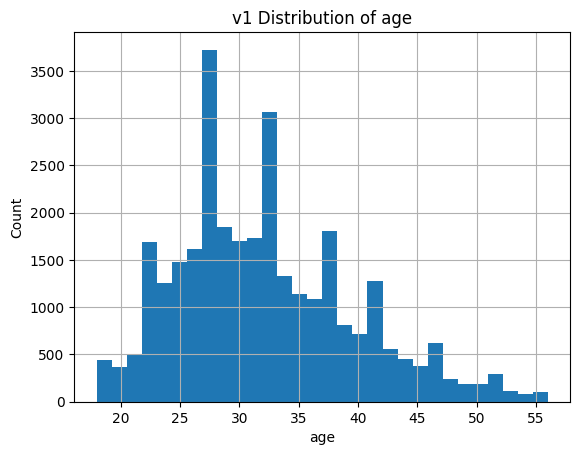

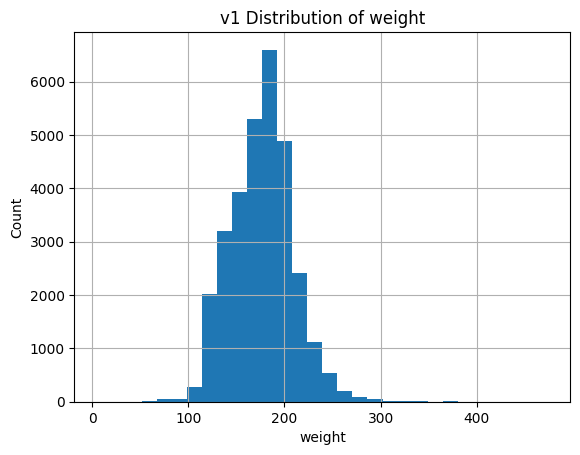

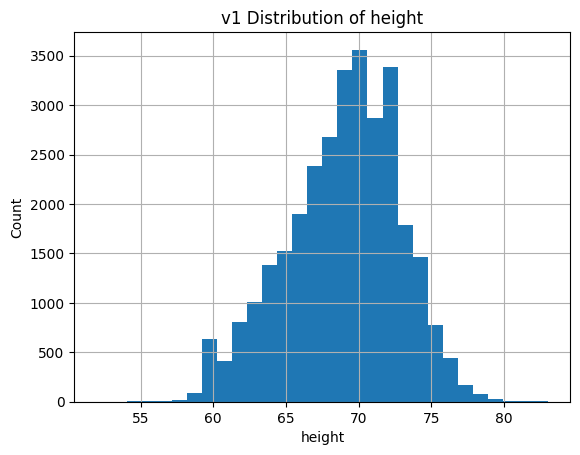

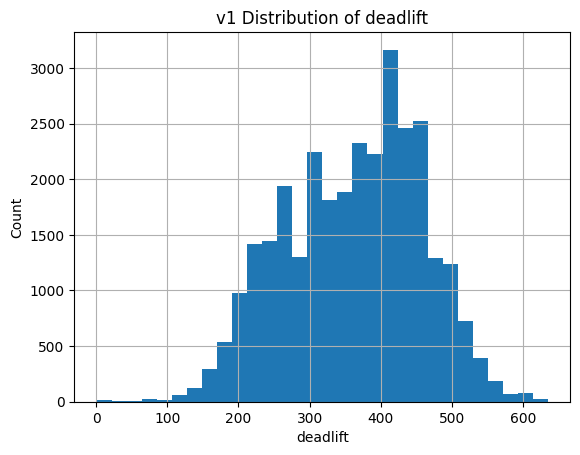

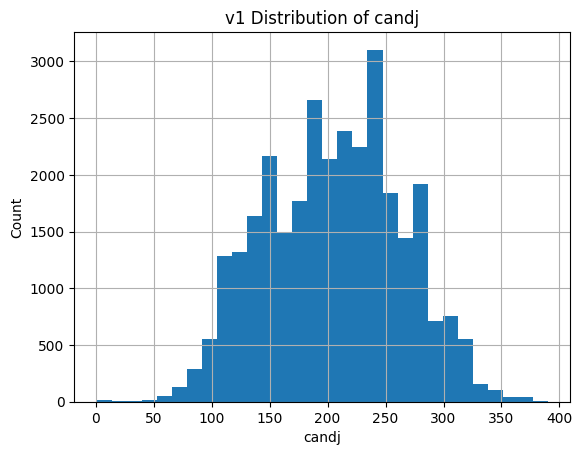

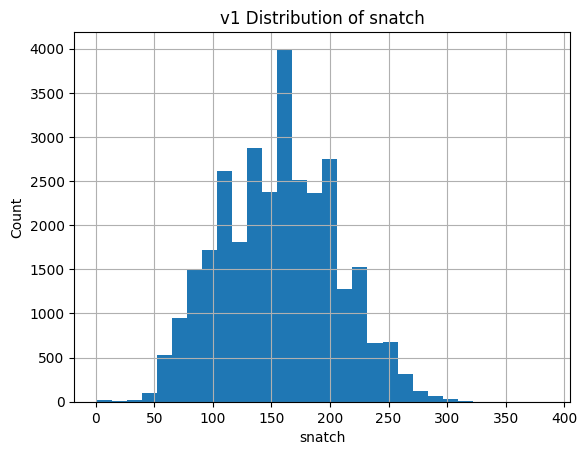

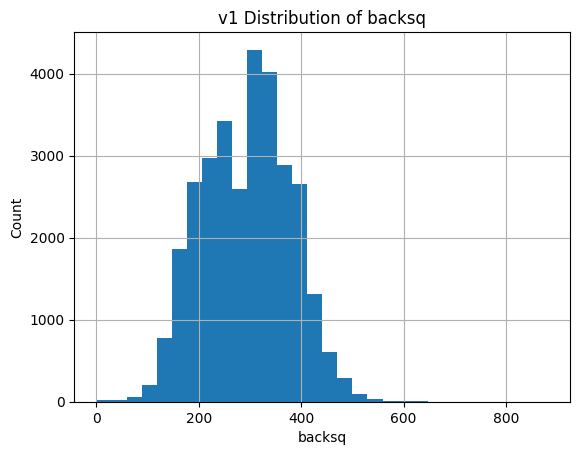

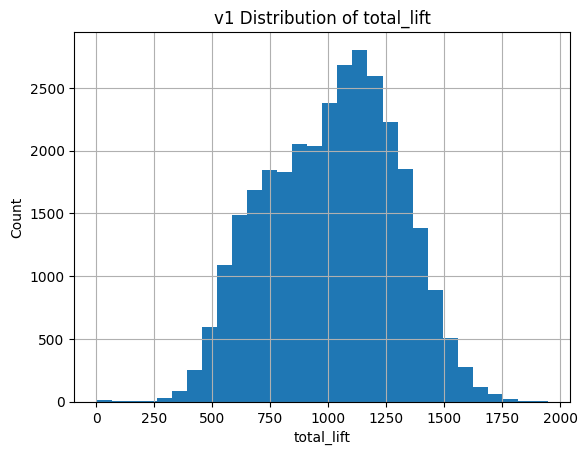

In [17]:
print("v2 shape:", df_v2_clean.shape)
print(df_v2_clean.describe(include="all"))

# Histograms of key numeric features
for col in ["age", "weight", "height", "deadlift", "candj", "snatch", "backsq", "total_lift"]:
    plt.figure()
    df_v2_clean[col].hist(bins=30)
    plt.title(f"v1 Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

### Model

In [18]:
X = df_v2_clean.drop(columns=["total_lift","total_lift", "candj", "snatch", "deadlift","backsq"], axis=1)
y = df_v2_clean['total_lift']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X,y,test_size=0.2, random_state=32)

model2 = RandomForestRegressor(random_state=32)
model2.fit(X_train_2,y_train_2)
y_pred_2 = model2.predict(X_test_2)

metrics_v2 = {
    "MAE": mean_absolute_error(y_test_2,y_pred_2),
    "R2": r2_score(y_test_2,y_pred_2)
}
print("Model 2 (v2) Metrics:", metrics_v2)

Model 2 (v2) Metrics: {'MAE': 136.2490628676721, 'R2': 0.6026758209439862}


In [124]:
df_v2_clean.to_csv("athletes_v2.csv", index=False)

In [ ]:
'''lakectl fs upload \
  lakefs://ml-ops-hw1-athletes/v2/athletes.csv \
  --source athletes_v2.csv'''

'''lakectl commit \
  lakefs://ml-ops-hw1-athletes/v2 \
  -m "v2: full cleaning + total_lift + region & gender encoding"'''